In [28]:
import math
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

import nmf.nmf as nmf
import knee.kneedle as kneedle

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture

In [2]:
df = pl.read_excel('db.xlsx')
df

#,abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,578,420,600,613,550,750,98.0,18.8,null
2,540,400,600,590,540,690,null,null,null
3,540,400,600,590,540,690,null,null,null
4,730,600,900,910,800,1000,null,2.5,null
5,730,600,900,910,800,1000,null,2.5,null
6,730,600,900,910,800,1000,null,4.0,null
7,730,600,900,910,800,1000,null,7.0,null
8,800,400,800,900,700,1000,30.0,1.4,3.2
9,600,400,600,630,600,700,50.0,0.5,1.2


In [3]:
df = df.drop(['#'])
df

abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
i64,i64,i64,i64,i64,i64,f64,f64,f64
578,420,600,613,550,750,98.0,18.8,null
540,400,600,590,540,690,null,null,null
540,400,600,590,540,690,null,null,null
730,600,900,910,800,1000,null,2.5,null
730,600,900,910,800,1000,null,2.5,null
730,600,900,910,800,1000,null,4.0,null
730,600,900,910,800,1000,null,7.0,null
800,400,800,900,700,1000,30.0,1.4,3.2
600,400,600,630,600,700,50.0,0.5,1.2


In [4]:
total, _ = df.shape
for col in df.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 19%
hopt (%): 36%
PCE (%): 47%


In [5]:
X = df.to_numpy()
X[np.isnan(X)] = 0
X

array([[5.78e+02, 4.20e+02, 6.00e+02, ..., 9.80e+01, 1.88e+01, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [5.10e+02, 2.50e+02, 5.20e+02, ..., 7.80e+01, 5.80e-02, 8.30e-04],
       [5.10e+02, 2.50e+02, 5.20e+02, ..., 7.80e+01, 1.70e+00, 1.40e-02],
       [5.75e+02, 4.00e+02, 6.10e+02, ..., 9.50e+01, 1.90e+01, 2.90e+00]])

In [6]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[106, 23, 10, 120, 51, 46, 42, 26, 139, 22, 111, 134, 94, 18, 100, 75, 11, 140, 129, 39, 43, 88, 102, 124, 96, 37, 108, 130, 74, 136, 79, 128, 138, 0]
[31, 140, 88, 66, 51, 30, 40, 139, 16, 14, 78, 15, 68, 67, 126, 46, 7, 93, 106, 19, 131, 13, 53, 69, 37, 11, 124]
[71, 80, 29, 142, 32, 97, 77, 113, 95, 52, 96, 94, 60, 85, 47, 87, 114, 86, 84, 21, 81, 83]


In [7]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[ 16.  78.  50.  53.  58.  45.  45.  25.  82.  14.  89.  65.  61. 100.
  93.  23.  67.  78.  30. 164.  94.  40.  44.  20.  30.  63.  89.  61.
  30.  70.  70.  50.  96.  98.]
[ 0.29   0.058  8.8   31.3    2.4    4.25  12.23   5.43   0.9    0.5
  1.5    1.     3.3   22.     7.58   1.4    1.4    9.     1.5    5.5
  3.3    0.6    1.2   27.8    3.67   3.4    2.01 ]
[4.40e-01 2.81e+00 2.60e+00 2.90e+00 2.20e+00 8.40e-04 7.90e+00 2.10e+00
 3.00e-02 3.94e+00 6.00e-04 2.00e-01 3.10e+00 1.90e-03 4.06e+00 7.00e-03
 2.10e+00 7.80e-04 1.13e+01 5.50e-01 7.10e+00 1.90e-01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [9]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [10]:
print(f"{cost} {solution}")

113.1970679067789 (8, 53)


In [11]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[20.09837235 19.11702724 32.11972792 88.9644563  18.5476325  19.13056727
 81.12812497 26.52153954 28.70805575 45.80126595 53.07554907 10.41728906
 63.81412985 71.873592   43.00608119 32.47692603 58.20705475 38.57911793
 23.16760599 11.31826616 58.01514344 53.64620133 32.90539979 24.47734987
 48.09369341 55.27645819 53.35330866 47.40150961 69.57413015 57.27963012
 44.66970465 64.73972997 43.31366419 91.73424347]
[ 9.31607961  6.11220767  8.53848923  8.4123451   3.62757438  6.43873654
  7.55587231  2.28964805  6.07920973  2.30163033  2.22157833  5.0174651
  2.52272798  5.74714778  2.53757779  3.44184049  7.54728576  6.52716512
  1.45166382  8.21198435  6.59784893  1.92411874  4.68912522  7.99681524
 11.44143736  8.25032953  4.47039206]
[2.64379541 0.99470483 2.72528206 1.22767343 3.03175617 1.43875088
 3.09988055 1.9995359  2.17905823 3.35257845 1.82509402 1.77645113
 3.23383947 2.24905051 2.73998968 2.27664157 1.48843236 3.45425549
 1.29836856 2.26527321 3.31697478 2.0120231 ]


In [12]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 39.85206587377582 (54.220689655172414 ± 29.73418013818261)
RMSE(HOPT): 7.648126511849703 (6.698021739130434 ± 9.9950685688083)
RMSE(PCE): 2.9574264641255414 (2.420651973684211 ± 2.970025846705724)


### Grid Search (optimize with test set)

In [13]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, _, _, _ = nmf.nmf_mu(X, k=k, seed=s)
        # Get the values with the mask
        hopt = Xr.T[7]
        PCE = Xr.T[8]
        hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
        PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]
        # Compute the cost of the test set
        rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
        rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))
        #cost = rmse_hopt + rmse_PCE
        #cost = rmse_hopt
        cost = rmse_PCE
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [14]:
print(f"{cost} {solution}")

2.697164757642897 (8, 97)


In [15]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 57.48502373  37.70065252  33.09210271  45.14727045  42.00317682
  45.83268804  49.45679785  19.26418133  54.20429116  66.22780057
  31.91327703 103.48191558  78.85578172  66.49540283  27.01878968
  23.63717811  52.64389501  80.66302416  12.10362633  58.26245286
  13.11841068  37.46793508  78.08397437  56.96578378  39.02955403
  65.89581831  56.03124901  47.06009743  82.35216062  27.66759317
  56.73719368  39.15213051 103.39766436  76.38680233]
[10.30838937 11.61559315  4.58596127 11.30414578  6.46719451  6.83049242
  4.9983862   7.38540386  6.31685849  1.83556846  3.17236005  5.55742689
  3.77291555  8.01750415  1.77741871  6.30738955  4.85983386  8.20835014
  8.12733835  9.00126568  8.13781005  0.75885278  2.91496305 10.26209747
  9.6300247   7.14594739  8.13302666]
[2.19264672 2.31771201 3.46176504 2.69395467 2.34643876 2.43451523
 3.90309195 1.44561203 1.30174277 2.29648095 1.63666039 2.43595169
 3.82707904 1.44694152 2.65953839 1.61921622 2.25231187 1.66859029
 1.67836716 2.52911

In [16]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 36.60081648347212 (54.220689655172414 ± 29.73418013818261)
RMSE(HOPT): 7.524799509467859 (6.698021739130434 ± 9.9950685688083)
RMSE(PCE): 2.697164757642897 (2.420651973684211 ± 2.970025846705724)


### Reconstruct the matrix

In [17]:
# Get the original matrix
X = df.to_numpy()
X[np.isnan(X)] = 0
print(X.shape)

# Get the reconstructed matrix
Xr, _, _, _ = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Replace all zeros with reconstructed values
X[X==0] = Xr[X==0]

(143, 9)


In [18]:
X

array([[5.78000000e+02, 4.20000000e+02, 6.00000000e+02, ...,
        9.80000000e+01, 1.88000000e+01, 2.79188714e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        5.63983688e+01, 7.84984799e+00, 2.20037835e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        2.58247068e+01, 3.74031753e+00, 1.75092923e+00],
       ...,
       [5.10000000e+02, 2.50000000e+02, 5.20000000e+02, ...,
        7.80000000e+01, 5.80000000e-02, 8.30000000e-04],
       [5.10000000e+02, 2.50000000e+02, 5.20000000e+02, ...,
        7.80000000e+01, 1.70000000e+00, 1.40000000e-02],
       [5.75000000e+02, 4.00000000e+02, 6.10000000e+02, ...,
        9.50000000e+01, 1.90000000e+01, 2.90000000e+00]])

In [19]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
_, cols = X.shape
field_names = df.columns
df = pl.DataFrame({field_names[i]: X[:,i] for i in range(cols)})
df

abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
f64,f64,f64,f64,f64,f64,f64,f64,f64
578.0,420.0,600.0,613.0,550.0,750.0,98.0,18.8,2.791887
540.0,400.0,600.0,590.0,540.0,690.0,56.398369,7.849848,2.200378
540.0,400.0,600.0,590.0,540.0,690.0,25.824707,3.740318,1.750929
730.0,600.0,900.0,910.0,800.0,1000.0,76.895199,2.5,3.175672
730.0,600.0,900.0,910.0,800.0,1000.0,21.612976,2.5,2.123806
730.0,600.0,900.0,910.0,800.0,1000.0,103.355105,4.0,3.573084
730.0,600.0,900.0,910.0,800.0,1000.0,90.537882,7.0,3.555733
800.0,400.0,800.0,900.0,700.0,1000.0,30.0,1.4,3.2
600.0,400.0,600.0,630.0,600.0,700.0,50.0,0.5,1.2


## Regression

In [20]:
# Get Output variables
PCE = df[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

hopt = df[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df.drop(['hopt (%)', 'PCE (%)'])
X = df.to_numpy()

In [21]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

models = [('Linear Regression', LinearRegression()),
          ('K Neighbors Regressor', KNeighborsRegressor()),
          ('Lasso Regression', Lasso(random_state=42)),
          ('Support Vector Regressor', SVR()),
          ('ANN', MLPRegressor(hidden_layer_sizes=(32,), max_iter=5000, random_state=42, learning_rate='adaptive')),
          ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
          ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42))]

## PCE
print(f'PCE')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_PCE, cv=5, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()
    
## HOPT
print(f'HOPT')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_hopt, cv=5, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

PCE
Linear Regression             : 6.30603251801406e-15
K Neighbors Regressor         : 1.61532584481687
Lasso Regression              : 0.36481008447359525
Support Vector Regressor      : 1.3081649687557406
ANN                           : 5.892231859225696
Random Forest Regressor       : 0.12231151806781768
Gradient Boosting Regressor   : 0.14022375908025211

HOPT
Linear Regression             : 1.4368623969895965e-14
K Neighbors Regressor         : 5.260278680804999
Lasso Regression              : 0.1023605773535178
Support Vector Regressor      : 4.779749285309387
ANN                           : 0.36660433928852126
Random Forest Regressor       : 0.6411008623463363
Gradient Boosting Regressor   : 0.5978958369057633



## Clustering

In [22]:
import sklearn.metrics as sklearn_metrics

def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0.0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [24]:
# Cluster the materials without the hopt and PCE
df_input = df.drop(['hopt (%)', 'PCE (%)'])
X = df.to_numpy()

scores = {'elbow': [], 'calinski-harabasz': [], 'davies-bouldin': [], 'silhouette': [], 'bic': [], }

min_k = 2
max_k = 20

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    labels = kmeans.labels_
    scores['elbow'].append(inertia_score(X, labels))
    scores['calinski-harabasz'].append(calinski_harabasz_score(X, labels))
    scores['davies-bouldin'].append(davies_bouldin_score(X, labels))
    scores['silhouette'].append(silhouette_score(X, labels))
    bic, _ = get_bic_aic(k, X)
    scores['bic'].append(bic)

print(f'{scores}')

{'elbow': [6456926.938134531, 4851069.193436539, 3994739.894392373, 3677081.860856726, 3243356.603744939, 2927431.309070684, 2822304.485656663, 2490930.5263413643, 2375997.5239118384, 2270967.8839577488, 2330201.866031744, 1949798.2476169611, 1759913.769853587, 1674239.2209135923, 1751839.5561168818, 1513481.666619205, 1542590.212184092, 1404217.612550997], 'calinski-harabasz': [169.0089161138328, 134.8526163470613, 118.3258598452732, 98.69770467698922, 92.53247760984696, 87.25464167792711, 77.7234597232165, 78.71279391199006, 73.51884487226877, 69.3170860190982, 60.64568566809496, 68.04420980550829, 70.12223715057812, 68.38278402821524, 60.14517517127321, 65.99266011496728, 60.316324628369095, 62.757035728830544], 'davies-bouldin': [0.7902121753855058, 1.0627944664383193, 1.1558287993749197, 1.339042878151675, 1.1045169586566708, 1.0297395830139395, 1.3694400217354332, 1.2868351172080825, 1.301226754973867, 1.3040584975949296, 1.203957403418631, 1.0377344849935985, 1.0593612311886471,

In [32]:
x = range(min_k, max_k)
y = scores['elbow']

points = np.zeros((len(y),2))
points[:,0] = x
points[:,1] = y

idx = kneedle.auto_knee(points)
print(f'{idx} {x[idx]}')

# calinski-harabasz" higher is better
# davies-bouldin lower is better
# silhouette higher is better
# bic higher is better

[[2.00000000e+00 6.45692694e+06]
 [3.00000000e+00 4.85106919e+06]
 [4.00000000e+00 3.99473989e+06]
 [5.00000000e+00 3.67708186e+06]
 [6.00000000e+00 3.24335660e+06]
 [7.00000000e+00 2.92743131e+06]
 [8.00000000e+00 2.82230449e+06]
 [9.00000000e+00 2.49093053e+06]
 [1.00000000e+01 2.37599752e+06]
 [1.10000000e+01 2.27096788e+06]
 [1.20000000e+01 2.33020187e+06]
 [1.30000000e+01 1.94979825e+06]
 [1.40000000e+01 1.75991377e+06]
 [1.50000000e+01 1.67423922e+06]
 [1.60000000e+01 1.75183956e+06]
 [1.70000000e+01 1.51348167e+06]
 [1.80000000e+01 1.54259021e+06]
 [1.90000000e+01 1.40421761e+06]]
5 7


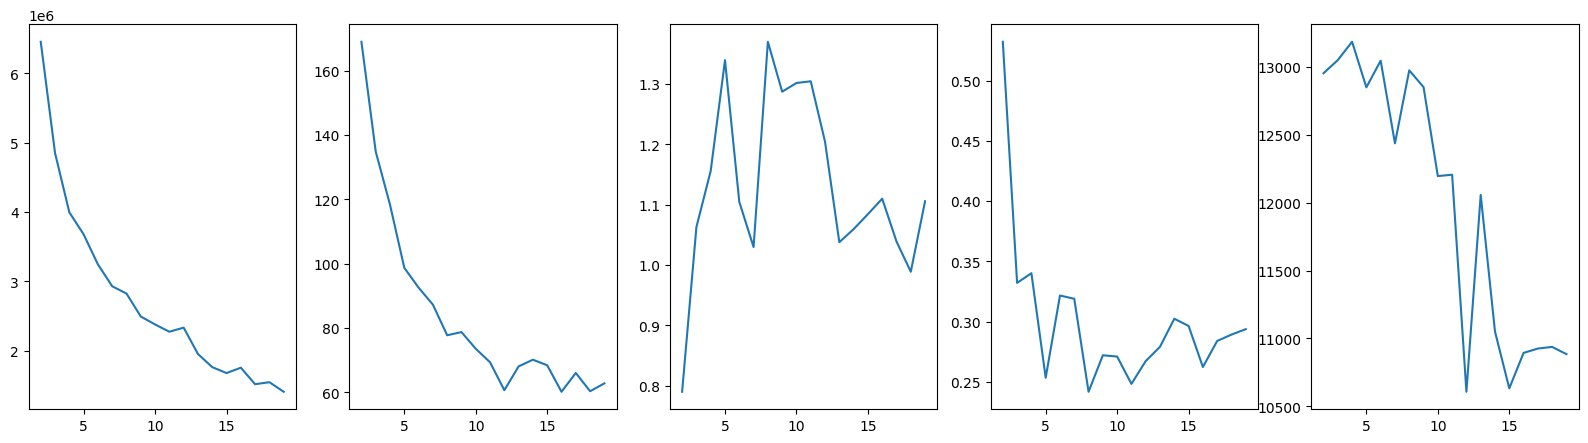

In [27]:
methods = ['elbow', 'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic']
fig, axs = plt.subplots(1, 5)

for i in range(len(methods)):
    method = methods[i]    
    axs[i].plot(range(min_k, max_k), scores[method])